In [1]:
import numpy as np
import pandas as pd

creating nodes

In [2]:
columns = ['coordinate_x','coordinate_y','displacement_x','displacement_y','load_x','load_y']
data = [[0,0,0,0,np.nan,np.nan],
        [20,0,np.nan,0,0,np.nan],
        [0,20,np.nan,np.nan,500,0]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,20,0,NaN,0.0,0.0,NaN
2,0,20,NaN,NaN,500.0,0.0


creating elements

In [3]:
columns = ['start','end','area','material']
data = [[0, 1, 2e-6, 10e9],
        [1, 2, 2e-6, 12e9],
        [2, 0, 3e-6, 10e9]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,area,material
0,0,1,0.000002,1.000000e+10
1,1,2,0.000002,1.200000e+10
2,2,0,0.000003,1.000000e+10


Finding length and global stiffness matrix

In [4]:
def compute(element):
    start = element['start']
    end = element['end']
    startX = nodes.loc[start,'coordinate_x']
    endX = nodes.loc[end,'coordinate_x']
    deltaX = (endX-startX)

    startY = nodes.loc[start,'coordinate_y']
    endY = nodes.loc[end,'coordinate_y']
    deltaY = (endY-startY)
    length = np.sqrt(deltaX**2 + deltaY**2)

    stiffness = element['area']*element['material']/length

    c = deltaX/length
    s = deltaY/length
    
    k = np.array([[c*c, c*s, -c*c, -c*s],
                  [c*s, s*s, -c*s, -s*s],
                  [-c*c, -c*s, c*c, c*s],
                  [-c*s, -s*s, c*s, s*s]])  
    
    return length, stiffness, k
elements[['length','stiffness','k']] = elements.apply(compute, axis=1, result_type='expand')
elements

,start,end,area,material,length,stiffness,k
0,0,1,0.000002,1.000000e+10,20.000000,1000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0..."
1,1,2,0.000002,1.200000e+10,28.284271,848.528137,"[[0.4999999999999999, -0.4999999999999999, -0...."
2,2,0,0.000003,1.000000e+10,20.000000,1500.000000,"[[0.0, -0.0, -0.0, 0.0], [-0.0, 1.0, 0.0, -1.0..."


In [5]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)
    K = np.zeros([N*2,N*2])
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['stiffness']*element['k']
    return K
K = elements.apply(compute_globalK,axis=1).sum()
K.round()

array([[ 1000.,     0., -1000.,     0.,     0.,     0.],
       [    0.,  1500.,     0.,     0.,     0., -1500.],
       [-1000.,     0.,  1424.,  -424.,  -424.,   424.],
       [    0.,     0.,  -424.,   424.,   424.,  -424.],
       [    0.,     0.,  -424.,   424.,   424.,  -424.],
       [    0., -1500.,   424.,  -424.,  -424.,  1924.]])

Solving element equations

In [6]:
def partition_k(K,A,B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement_x','displacement_y']].to_numpy()
U = U.ravel() # converts into 1d row matrix
A = np.isnan(U)

P = nodes[['load_x','load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K, A, B)

In [7]:
# known displacement, UB
UB = U[B]
# known load, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

Post processing

In [8]:
results = nodes.copy()
results[['displacement_x','displacement_y']] = U.reshape(-1,2)
results[['load_x','load_y']] = P.reshape(-1,2)
results

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000,0.000000,-500.0,-500.0
1,20,0,0.500000,0.000000,0.0,500.0
2,0,20,2.011845,0.333333,500.0,0.0


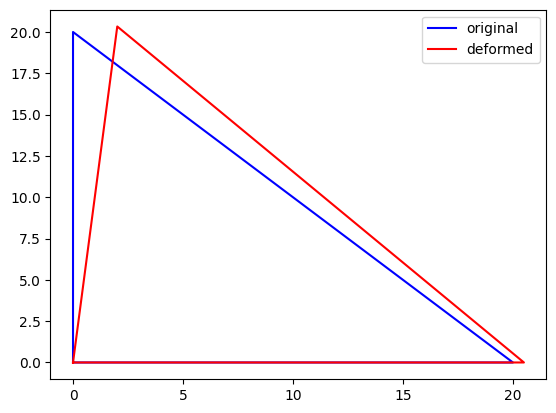

In [9]:
import matplotlib.pyplot as plt
factor = 1
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_y'] = results['coordinate_y'] + factor*results['displacement_y']
results.loc[3] = results.loc[0] # adding a new row with values as first row

plt.plot(results['coordinate_x'],results['coordinate_y'],'b-', label = 'original')
plt.plot(results['deformed_x'],results['deformed_y'],'r-', label = 'deformed')
plt.legend()
# plt.axis('off')
plt.show()